# Abstract
- Data Understanding
    - A long answer would be a longer section of text that answers the question - several sentences or a paragraph.
    - A short answer might be a sentence or phrase, or even in some cases a YES/NO.
    - The short answers are always contained within / a subset of one of the plausible long answers. 
    - A given article can (and very often will) allow for both long and short answers, depending on the question.
- Data Statistics
    - training data contains 307,373 examples. 152,148 have a long answer and 110,724 have a short answer.
- Number of Long Answer Candidate
    - Some of data for long answers are swamped with a lot of candidates (7946 in maximum!)
    - n_long_candidates_train is long-tail distribution, range in [1, 7946]
    - n_long_candidates_train and n_long_candidates_test have similar distribution
- Short answer
    - Short answers can be sets of spans in the document (106,926), or yes or no (3,798).
    - 63.47% 'NO ANSWERS' in short answer labels
    - one question can have multiple short answers within same long anwser
    - when yes-no answer is not 'None' (i.e. yes or no), short answer always be empty
- Yes-no Answer
    - significant class imbalance in yes-no answer labels, 98% answer is 'None'.
- Long Answer
    - long answer can either be 0（denoted by 'start_token': -1）or 1 
    - long answer must be selected from long_answer_candidates
    - 50.5% of 'NO ANSWERS' in long answer labels
    - when the start token and/or the end token are -1, yes-no answer is 'NONE'
    - yes-no answer 'NONE' does not always mean that the start token and/or the end token are -1
    - About 95% long answer's top_level is true
- Text Word Counts
    - Words counts of question text range in [0, 30]
    - Words counts of d document text range in [0, 120000]
    - Words counts of short answers text is long-tail distribution, range in [1, 250]
    - Words counts of long answers text is long-tail distribution, range in [5, 123548]

# Preparation

In [15]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from IPython.core.display import HTML

In [16]:
DIR = '../input/tensorflow2-question-answering/'
PATH_TRAIN = DIR + 'simplified-nq-train.jsonl'
PATH_TEST = DIR + 'simplified-nq-test.jsonl'

## Number of samples in train & test dataset

In [17]:
!wc -l '../input/tensorflow2-question-answering/simplified-nq-train.jsonl'
!wc -l '../input/tensorflow2-question-answering/simplified-nq-test.jsonl'

307373 ../input/tensorflow2-question-answering/simplified-nq-train.jsonl
345 ../input/tensorflow2-question-answering/simplified-nq-test.jsonl


# Load .jsonl file iteratively

As we know, one of the most common way to convert .jsonl file into pd.DataFrame is  `pd.read_json(FILENAME, orient='records', lines=True)`:

In [18]:
df_test = pd.read_json(PATH_TEST, orient='records', lines=True)
df_test.head()

,example_id,question_text,document_text,long_answer_candidates
0,-1220107454853145600,who is the south african high commissioner in ...,"High Commission of South Africa , London - wik...","[{'end_token': 136, 'start_token': 18, 'top_le..."
1,8777415633185303552,the office episode when they sing to michael,Michael 's Last Dundies - wikipedia <H1> Micha...,"[{'end_token': 190, 'start_token': 23, 'top_le..."
2,4640548859154538496,what is the main idea of the cross of gold speech,Cross of gold speech - wikipedia <H1> Cross of...,"[{'end_token': 165, 'start_token': 12, 'top_le..."
3,-5316095317154496512,when was i want to sing in opera written,Wilkie Bard - wikipedia <H1> Wilkie Bard </H1>...,"[{'end_token': 105, 'start_token': 8, 'top_lev..."
4,-8752372642178983936,who does the voices in ice age collision course,Ice Age : Collision Course - Wikipedia <H1> Ic...,"[{'end_token': 287, 'start_token': 16, 'top_le..."


However, since we have a **HUGE train dataset** for this competition, Kaggle Notebook RAM cannot afford this method.
Instead, we probablly have to load the train dataset iteratively:

In [19]:
json_train = []

with open(PATH_TRAIN, 'rt') as f:
    for i in tqdm(f):
        json_train.append(json.loads(i.strip()))

307373it [01:49, 2813.85it/s]


In [20]:
df_train = pd.DataFrame(json_train)
df_train.head()

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018


In [21]:
df_train.iloc[0].loc['long_answer_candidates'][:10]

[{'start_token': 14, 'top_level': True, 'end_token': 170},
 {'start_token': 15, 'top_level': False, 'end_token': 169},
 {'start_token': 52, 'top_level': False, 'end_token': 103},
 {'start_token': 53, 'top_level': False, 'end_token': 102},
 {'start_token': 103, 'top_level': False, 'end_token': 156},
 {'start_token': 104, 'top_level': False, 'end_token': 155},
 {'start_token': 170, 'top_level': True, 'end_token': 321},
 {'start_token': 171, 'top_level': False, 'end_token': 180},
 {'start_token': 180, 'top_level': False, 'end_token': 186},
 {'start_token': 186, 'top_level': False, 'end_token': 224}]

In [113]:
df_train.iloc[9].loc['annotations']

[{'yes_no_answer': 'NONE',
  'long_answer': {'start_token': -1, 'candidate_index': -1, 'end_token': -1},
  'short_answers': [],
  'annotation_id': 9055562038158888262}]

# Data Visualization

## Obtain data

We must be cautious that <span style="color: red">**"short answer" for this competition corresponds to "yes-no answer" in the original dataset**.</span>  

In [120]:
N_TRAIN = 307373
n_long_candidates_train = np.zeros(N_TRAIN)
t_long_train = np.zeros((N_TRAIN,2))  # [start_token, end_token]
t_yesno_train = []
t_short_train = []
top_level = []

with open(PATH_TRAIN, 'rt') as f:
    for i in tqdm(range(N_TRAIN), position=0, leave=True):
        dic = json.loads(f.readline())
        n_long_candidates_train[i] = len(dic['long_answer_candidates'])
        t_long_train[i,0] = dic['annotations'][0]['long_answer']['start_token']
        t_long_train[i,1] = dic['annotations'][0]['long_answer']['end_token']
        t_yesno_train.append(dic['annotations'][0]['yes_no_answer'])
        t_short_train.append(len(dic['annotations'][0]['short_answers']))
        long_answer_candidate_index = dic['annotations'][0]['long_answer']['candidate_index']
        if long_answer_candidate_index != -1:
            top_level.append(dic['long_answer_candidates'][long_answer_candidate_index]['top_level'])

100%|██████████| 307373/307373 [01:17<00:00, 3989.80it/s]


In [25]:
N_TEST = 345
n_long_candidates_test = np.zeros(N_TEST)

In [26]:
with open(PATH_TEST, 'rt') as f:
    for i in tqdm(range(N_TEST)):
        dic = json.loads(f.readline())
        n_long_candidates_test[i] = len(dic['long_answer_candidates'])

100%|██████████| 345/345 [00:00<00:00, 2649.06it/s]


## Visualization

In [27]:
plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-poster')

### Take a glance at data

In [28]:
def show_example(example_id):
    example = df_train[df_train['example_id']==example_id]
    document_text = example['document_text'].values[0]
    question = example['question_text'].values[0]

    annotations = example['annotations'].values[0]
    la_start_token = annotations[0]['long_answer']['start_token']
    la_end_token = annotations[0]['long_answer']['end_token']
    long_answer = " ".join(document_text.split(" ")[la_start_token:la_end_token])
    short_answers = annotations[0]['short_answers']
    sa_list = []
    for sa in short_answers:
        sa_start_token = sa['start_token']
        sa_end_token = sa['end_token']
        short_answer = " ".join(document_text.split(" ")[sa_start_token:sa_end_token])
        sa_list.append(short_answer)
    
    document_text = document_text.replace(long_answer,'<LALALALA>')
    sa=False
    la=''
    
    # fix empty short_answers bug
    if short_answers:
        for sa in short_answers:
            sa_start_token = sa['start_token']
            sa_end_token = sa['end_token']
            for i,laword in enumerate(long_answer.split(" ")):
                ind = i+la_start_token
                if ind==sa_start_token:
                    la = la+' SASASASA'+laword
                elif ind==sa_end_token-1:
                    la = la+' '+laword+'SESESESE'
                else:
                    la = la+' '+laword
    else:
        la=long_answer
#     print(la)
    html = '<div style="font-weight: bold;font-size: 20px;color:#00239CFF">Example Id</div><br/>'
    html = html + '<div>' + str(example_id) + '</div><hr>'
    html = html + '<div style="font-weight: bold;font-size: 20px;color:#00239CFF">Question</div><br/>'
    html = html + '<div>' + question + ' ?</div><hr>'
    html = html + '<div style="font-weight: bold;font-size: 20px;color:#00239CFF">Document Text</div><br/>'
    
    if la_start_token==-1:
        html = html + '<div>There are no answers found in the document</div><hr>'
    else:
        la = la.replace('SASASASA','<span style="background-color:#C7D3D4FF; padding:5px"><font color="#000">')
        la = la.replace('SESESESE','</font></span>')
        document_text = document_text.replace('<LALALALA>','<div style="background-color:#603F83FF; padding:5px"><font color="#fff">'+la+'</font></div>')

        #for simplicity, trim words from end of the document
        html = html + '<div>' + " ".join(document_text.split(" ")[:la_end_token+200]) + ' </div>'
    display(HTML(html))

To keep scroll bar short, content from the document text is trimmed at the end.

**Long answer is highlighted in dark blue, and short answers are in light blue.**

In [29]:
show_example(5328212470870865242)

### Long answer candidates

Some of data for long answers are swamped with a lot of candidates (**7946 in maximum!**):

In [30]:
pd.Series(n_long_candidates_train).describe()

count    307373.000000
mean        131.354185
std         170.104565
min           1.000000
25%          45.000000
50%          87.000000
75%         158.000000
max        7946.000000
dtype: float64

In [31]:
pd.Series(n_long_candidates_test).describe()

count     345.000000
mean      130.710145
std       171.995834
min         2.000000
25%        48.000000
50%        86.000000
75%       155.000000
max      1837.000000
dtype: float64

n_long_candidates_train is long-tail distribution, range in [1, 7946]

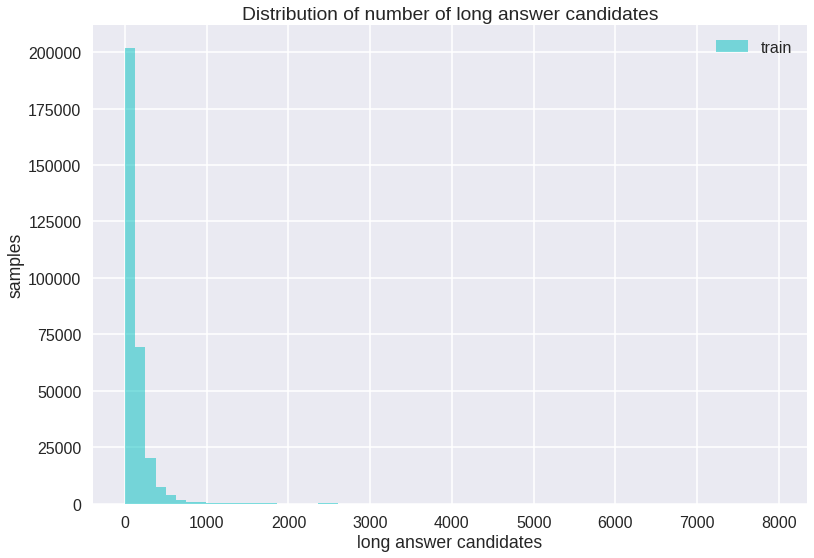

In [35]:
plt.hist(n_long_candidates_train, bins=64, alpha=0.5, color='c', label='train')
plt.xlabel('long answer candidates')
plt.ylabel('samples')
plt.title("Distribution of number of long answer candidates")
plt.legend()

n_long_candidates_train and n_long_candidates_test have similar distribution

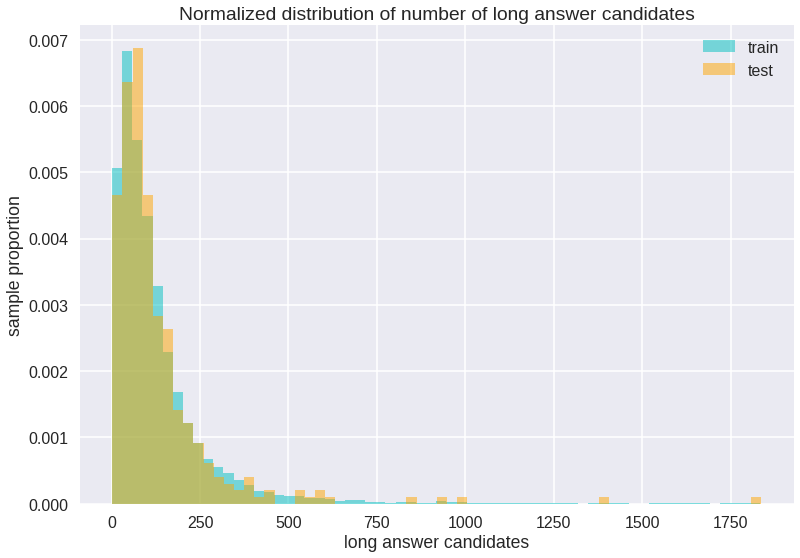

In [37]:
plt.hist(n_long_candidates_train[n_long_candidates_train < np.max(n_long_candidates_test)], density=True, bins=64, alpha=0.5, color='c', label='train')
plt.hist(n_long_candidates_test, density=True, bins=64, alpha=0.5, color='orange', label='test')
plt.xlabel('long answer candidates')
plt.ylabel('sample proportion')
plt.title("Normalized distribution of number of long answer candidates")
plt.legend()

### Short answer labels

- 63.47% 'NO ANSWERS' in short answer labels
- one question can have multiple short answers within same long anwser
- when yes-no answer is not 'None' (i.e. yes or no), short answer always be empty

In [230]:
pd.Series(t_short_train).describe()

count    307373.000000
mean          0.423697
std           0.785533
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          25.000000
dtype: float64

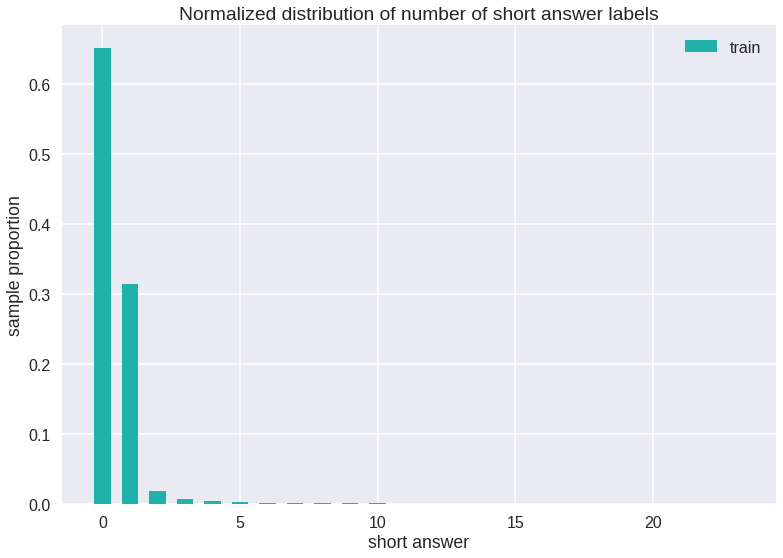

In [38]:
plt.hist(t_short_train, bins=range(max(t_short_train)), align='left', density=True, rwidth=0.6, color='lightseagreen', label='train')
plt.xlabel('short answer')
plt.ylabel('sample proportion')
plt.title("Normalized distribution of number of short answer labels")
plt.legend()

a example with multiple short answers

In [39]:
show_example(-1413521544318030897)

when yes-no answer is not 'None' (i.e. yes or no), short answer always be empty

In [40]:
# no_answer_state[1,:] is the number of train data whose short answer is empty
# no_answer_state[:,0] is the number of train data whose yes-no answer is 'YES' OR 'NO'
t_short_train = np.array(t_short_train)
yesno_answer_state = np.zeros((2,2))
yesno_answer_state[1,1] = np.sum((t_short_train==0) * (np.array([ 1 if t=='NONE' else 0 for t in t_yesno_train ])))
yesno_answer_state[1,0] = np.sum((t_short_train==0) * (np.array([ 0 if t=='NONE' else 1 for t in t_yesno_train ])))
yesno_answer_state[0,1] = np.sum((t_short_train>0) * (np.array([ 1 if t=='NONE' else 0 for t in t_yesno_train ])))
yesno_answer_state[0,0] = np.sum((t_short_train>0) * (np.array([ 0 if t=='NONE' else 1 for t in t_yesno_train ])))        

In [41]:
yesno_answer_state

array([[     0., 106926.],
       [  3798., 196649.]])

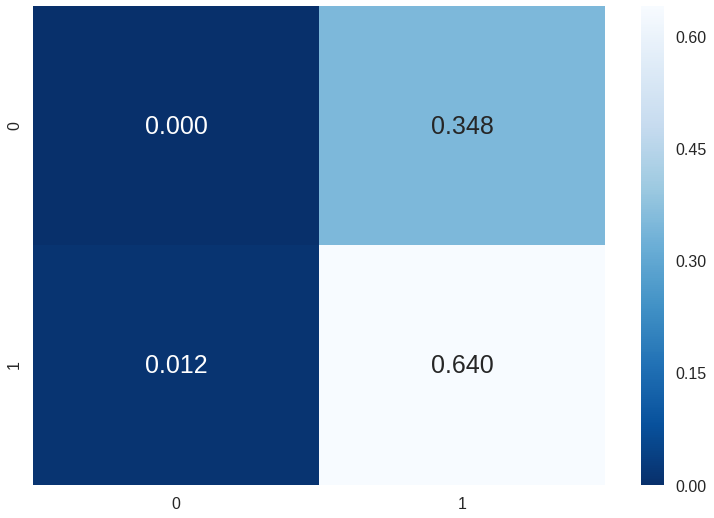

In [42]:
sns.heatmap(yesno_answer_state / N_TRAIN, annot=True, annot_kws={"size": 25}, fmt='.3f', cmap='Blues_r')

### Number of Yes-no answer labels

We can see significant class imbalance in yes-no answer labels.

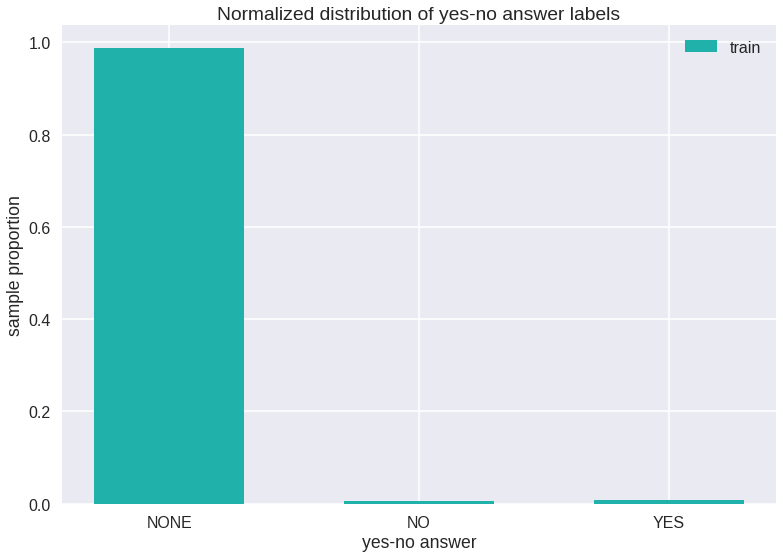

In [43]:
plt.hist(t_yesno_train, bins=[0,1,2,3], align='left', density=True, rwidth=0.6, color='lightseagreen', label='train')
plt.xlabel('yes-no answer')
plt.ylabel('sample proportion')
plt.title("Normalized distribution of yes-no answer labels")
plt.legend()

#### Example of NO

In [196]:
df_train[df_train.example_id==3817861884803470204]['annotations'].iloc[0]

[{'yes_no_answer': 'NO',
  'long_answer': {'start_token': 6539,
   'candidate_index': 77,
   'end_token': 6646},
  'short_answers': [],
  'annotation_id': 13761098100656608312}]

#### Example of YES

In [197]:
df_train[df_train.example_id==5429746486027633157]['annotations'].iloc[0]

[{'yes_no_answer': 'YES',
  'long_answer': {'start_token': 1353,
   'candidate_index': 15,
   'end_token': 1376},
  'short_answers': [],
  'annotation_id': 15266883435030073863}]

### Long answer labels

Description of start token labels:

In [44]:
pd.Series(t_long_train[:,0]).describe()

count    307373.000000
mean        532.571589
std        1600.149053
min          -1.000000
25%          -1.000000
50%          -1.000000
75%         367.000000
max       87343.000000
dtype: float64

Desciption of end token labels:

In [45]:
pd.Series(t_long_train[:,1]).describe()

count    307373.000000
mean        722.793020
std        2041.141321
min          -1.000000
25%          -1.000000
50%          -1.000000
75%         535.000000
max      123780.000000
dtype: float64

We can see below that nearly half of the long answers have start/end token -1.  
In other words, there are a 50.5% of '**NO ANSWERS**' in long answer labels, not only in yes-no labels:

In [46]:
print('{0:.1f}% of start tokens are -1.'.format(np.sum(t_long_train[:,0] < 0) / N_TRAIN * 100))
print('{0:.1f}% of end tokens are -1.'.format(np.sum(t_long_train[:,1] < 0) / N_TRAIN * 100))

50.5% of start tokens are -1.
50.5% of end tokens are -1.


**If the start token is -1, the corresponding end token is also -1**:

In [47]:
np.sum(t_long_train[:,0] * t_long_train[:,1] < 0)

0

The heatmap below tells us that:
- when the start token and/or the end token are -1, yes-no answer is 'NONE'
- yes-no answer 'NONE' does not always mean that the start token and/or the end token are -1

In [48]:
# no_answer_state[1,:] is the number of train data whose start token and end token are -1
# no_answer_state[:,1] is the number of train data whose yes-no answer is 'NONE'

no_answer_state = np.zeros((2,2))
no_answer_state[1,1] = np.sum((t_long_train[:,0]==-1) * (np.array([ 1 if t=='NONE' else 0 for t in t_yesno_train ])))
no_answer_state[1,0] = np.sum((t_long_train[:,0]==-1) * (np.array([ 0 if t=='NONE' else 1 for t in t_yesno_train ])))
no_answer_state[0,1] = np.sum((t_long_train[:,0]>=0) * (np.array([ 1 if t=='NONE' else 0 for t in t_yesno_train ])))
no_answer_state[0,0] = np.sum((t_long_train[:,0]>=0) * (np.array([ 0 if t=='NONE' else 1 for t in t_yesno_train ])))                             

In [49]:
no_answer_state

array([[  3798., 148350.],
       [     0., 155225.]])

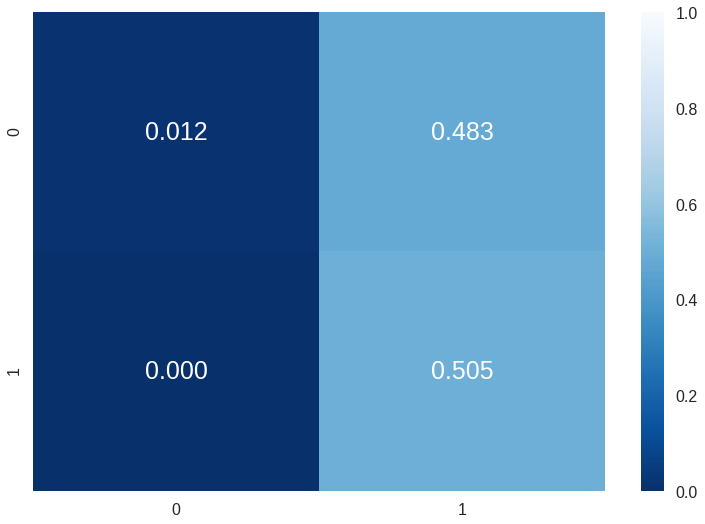

In [50]:
sns.heatmap(no_answer_state / N_TRAIN, annot=True, annot_kws={"size": 25}, fmt='.3f', vmin=0, vmax=1, cmap='Blues_r')

#### top_level
About 95% long answer's top_level is true

In [134]:
series_top_level = pd.Series(top_level)
series_top_level.value_counts(normalize=True)

True     0.949405
False    0.050595
dtype: float64

## Text Word Counts

Let us look into word counts of question texts & document texts.

### Obtain data

In [67]:
q_lens_train = np.zeros(N_TRAIN)
d_lens_train = np.zeros(N_TRAIN)

In [68]:
[{'yes_no_answer': 'NONE',
  'long_answer': {'start_token': 1952,
   'candidate_index': 54,
   'end_token': 2019},
  'short_answers': [{'start_token': 1960, 'end_token': 1969}],
  'annotation_id': 593165450220027640}]

[{'yes_no_answer': 'NONE',
  'long_answer': {'start_token': 1952,
   'candidate_index': 54,
   'end_token': 2019},
  'short_answers': [{'start_token': 1960, 'end_token': 1969}],
  'annotation_id': 593165450220027640}]

In [138]:
short_answer_lens_train = []
long_answer_lens_train = []
with open(PATH_TRAIN, 'rt') as f:
    for i in tqdm(range(N_TRAIN), position=0, leave=True):
        dic = json.loads(f.readline())
        q_lens_train[i] = len(dic['question_text'].split())
        d_lens_train[i] = len(dic['document_text'].split())
        for annotation in dic["annotations"]:
            long_answer_len = annotation["long_answer"]["end_token"] - annotation["long_answer"]["start_token"]
            if long_answer_len != 0:
                long_answer_lens_train.append(long_answer_len)
            for short_answer in annotation['short_answers']:
                short_answer_len = short_answer["end_token"] - short_answer["start_token"]
                short_answer_lens_train.append(short_answer_len)

100%|██████████| 307373/307373 [04:01<00:00, 1271.82it/s]


In [53]:
q_lens_test = np.zeros(N_TEST)
d_lens_test = np.zeros(N_TEST)

In [56]:
with open(PATH_TEST, 'rt') as f:
    for i in tqdm(range(N_TEST)):
        dic = json.loads(f.readline())
        q_lens_test[i] = len(dic['question_text'].split())
        d_lens_test[i] = len(dic['document_text'].split())


100%|██████████| 345/345 [00:00<00:00, 1030.25it/s]


### Visualization

#### Word counts of question text

Words counts of question text range in [0, 30]

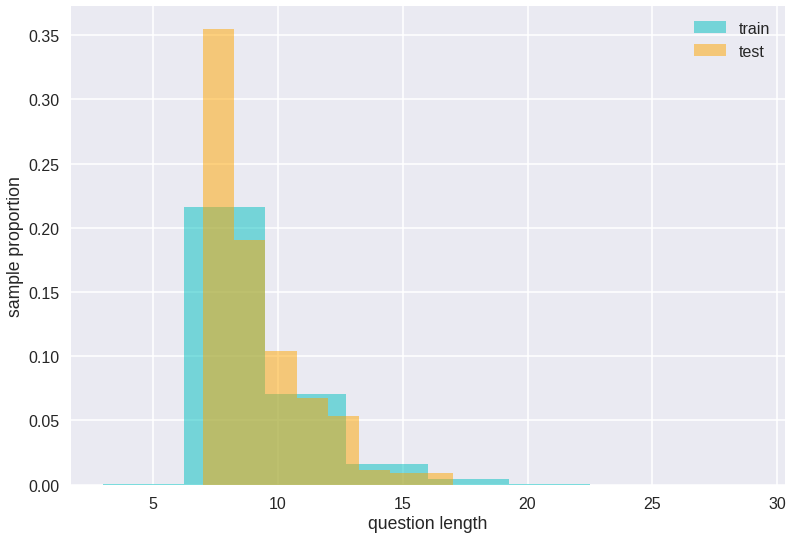

In [139]:
plt.hist(q_lens_train, density=True, bins=8, alpha=0.5, color='c', label='train')
plt.hist(q_lens_test, density=True, bins=8, alpha=0.5, color='orange', label='test')
plt.xlabel('question length')
plt.ylabel('sample proportion')
plt.legend()

#### Word counts of document text

Words counts of d document text range in [0, 120000]

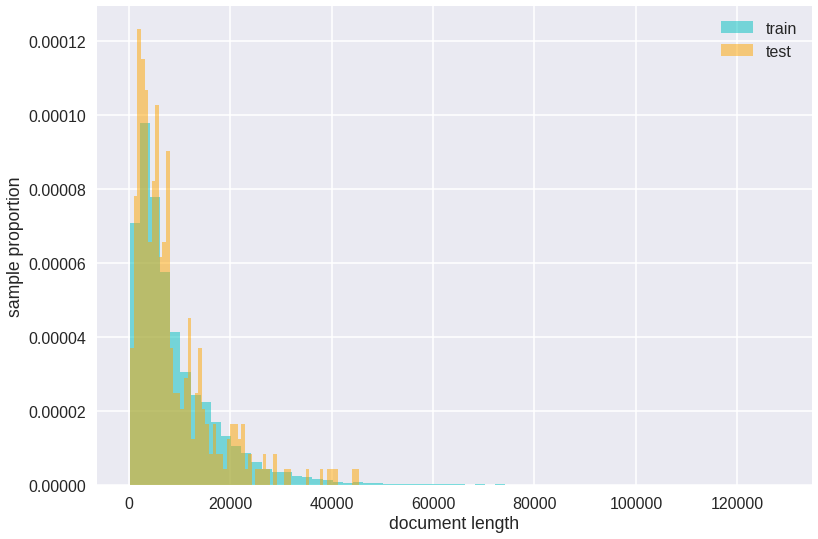

In [174]:
plt.hist(d_lens_train, density=True, bins=64, alpha=0.5, color='c', label='train')
plt.hist(d_lens_test, density=True, bins=64, alpha=0.5, color='orange', label='test')
plt.xlabel('document length')
plt.ylabel('sample proportion')
plt.legend()

#### Word counts of short answers text
Words counts of short answers text is long-tail distribution, range in [1, 250]

count    130233.000000
mean          4.096942
std           5.972028
min           1.000000
25%           2.000000
50%           2.000000
75%           4.000000
max         250.000000
dtype: float64


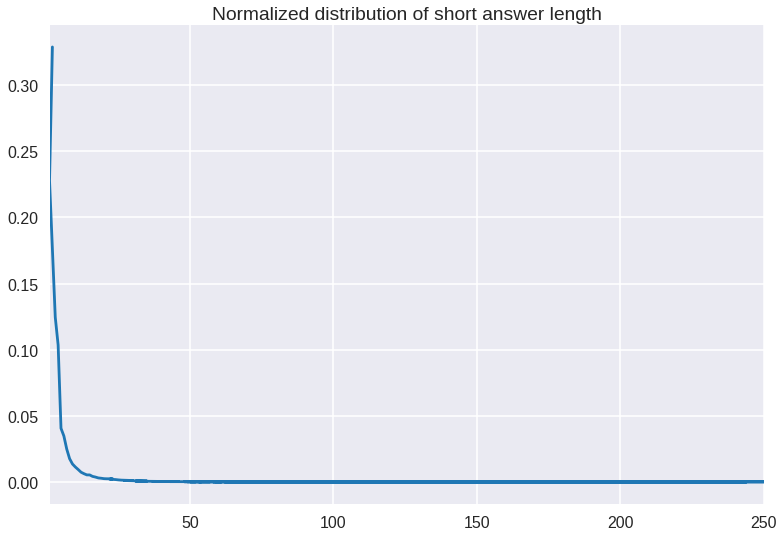

In [110]:
series_short = pd.Series(short_answer_lens_train)
print(series_short.describe())
series_short.value_counts(normalize=True).plot(kind='line', title="Normalized distribution of short answer length")

#### Word counts of long answers text
Words counts of long answers text is long-tail distribution, range in [5, 123548]

count    152148.000000
mean        384.289849
std        1496.184997
min           5.000000
25%          75.000000
50%         117.000000
75%         192.000000
max      123548.000000
dtype: float64


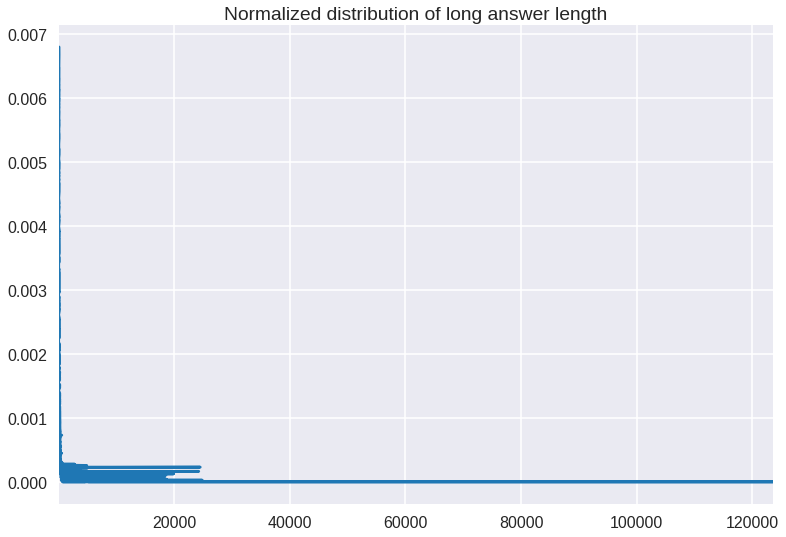

In [143]:
series_long = pd.Series(long_answer_lens_train)
print(series_long.describe())
series_long.value_counts(normalize=True).plot(kind='line', title="Normalized distribution of long answer length")

# Feature Visualiztion

## Answer type labels

In [1]:
import tensorflow as tf

In [2]:
raw_dataset = tf.data.TFRecordDataset("../input/bertjointbaseline/nq-train.tfrecords-00000-of-00001")

In [7]:
all_answer_types = []
for raw_record in tqdm(raw_dataset, desc="Parsing tfrecod"):
    f = tf.train.Example.FromString(raw_record.numpy())
    all_answer_types.append(f.features.feature["answer_types"].int64_list.value)

Parsing tfrecod: 494670it [01:25, 5790.53it/s]


In [17]:
id2label = ["unk", "yes", "no", "short", "long"]

In [19]:
s_at = pd.Series(all_answer_types).apply(lambda x: id2label[x[0]])

short    0.507807
unk      0.341116
long     0.137655
yes      0.008404
no       0.005017
dtype: float64


/users/liukanglong/.conda/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  This is separate from the ipykernel package so we can avoid doing imports until


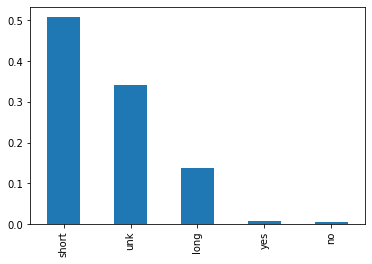

In [27]:
stats=s_at.value_counts(normalize=True)
print(stats)
stats.plot("bar")